# بسم الله الرحمن الرحيم


# About Dataset


Access to safe drinking-water is essential to health, a basic human right and a component of effective policy for health protection. This is important as a health and development issue at a national, regional and local level. In some regions, it has been shown that investments in water supply and sanitation can yield a net economic benefit, since the reductions in adverse health effects and health care costs outweigh the costs of undertaking the interventions. so developping models and methods to predict and test the potability of water for human consummation is of huge benefits.

In [ ]:
import pandas as pd
import seaborn as sns
import missingno as msn
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
 

In [ ]:
sequential_colors = sns.color_palette("RdGy",2)
sns.palplot(sequential_colors)

In [ ]:
data={"1. pH value":"""recommended  pH from 6.5 to 8.5""","2. Hardness":"The capacity of water to precipitate soap caused by Calcium and Magnesium","3. Total dissolved solids - TDS":"Desirable limit is 500 mg/l and maximum 1000 mg/l ","4. Chloramines":"up to 4 milligrams per liter (mg/L or 4 ppm) are considered safe","5. Sulfate":"from 3 to 30 mg/L in most freshwater supplies","6. Conductivity":"not exceeded 400 μS/cm.","7. Total_Organic_carbon(TOC)":"EPA < 2 mg/L as TOC in treated drinking water, and < 4 mg/Lit in source water","8. Trihalomethanes":"up to 80 ppm is considered safe","9. Turbidity":"WHO recommended value of 5.00 NTU.","10. Potability":"Indicates if water is safe for human consumption"}

In [ ]:
dataset=pd.DataFrame(data,index=["limits"])
dataset

# 1- Get The Data

In [ ]:
Water_Ch = pd.read_csv("../input/water-potability/water_potability.csv")

# 2- Take a look at the Data structure 

In [ ]:
Water_Ch.head(3)

pH value

In [ ]:
Water_ph=Water_Ch[(Water_Ch.ph<6.5) | (Water_Ch.ph>8.5)]
outlimit_ph=pd.Series(Water_ph["Potability"].value_counts())
pd.DataFrame(outlimit_ph)

pH is outlimits but still some values give potability indication so we will reclassify it 

In [ ]:
Water_Ch.loc[~Water_Ch.ph.between(6.5, 8.5), 'Potability'] = 0

In [ ]:
Water_ph=Water_Ch[(Water_Ch.ph<6.5) | (Water_Ch.ph>8.5)]
outlimit_ph=pd.Series(Water_ph["Potability"].value_counts())
pd.DataFrame(outlimit_ph)

Hardness

In [ ]:
Water_Hardness=Water_Ch.loc[(Water_Ch.Hardness<=500)]
outlimit_Hardness=pd.Series(Water_Hardness["Potability"].value_counts())
pd.DataFrame(outlimit_Hardness)

Hardness value within the acceptable limits

solids

In [ ]:
Water_solids=Water_Ch.loc[(Water_Ch.Solids>1000)]
outlimit_solid=pd.Series(Water_solids["Potability"].value_counts())
pd.DataFrame(outlimit_solid)

Although Solids Also is outlimits of WHO but it represent most of data so we can not reclassify it

But in the same time there are strong relation ship between solids and EC as below link


https://www.researchgate.net/figure/Relationship-between-electrical-conductivity-EC-and-total-dissolved-solids-TDS_fig10_227328358

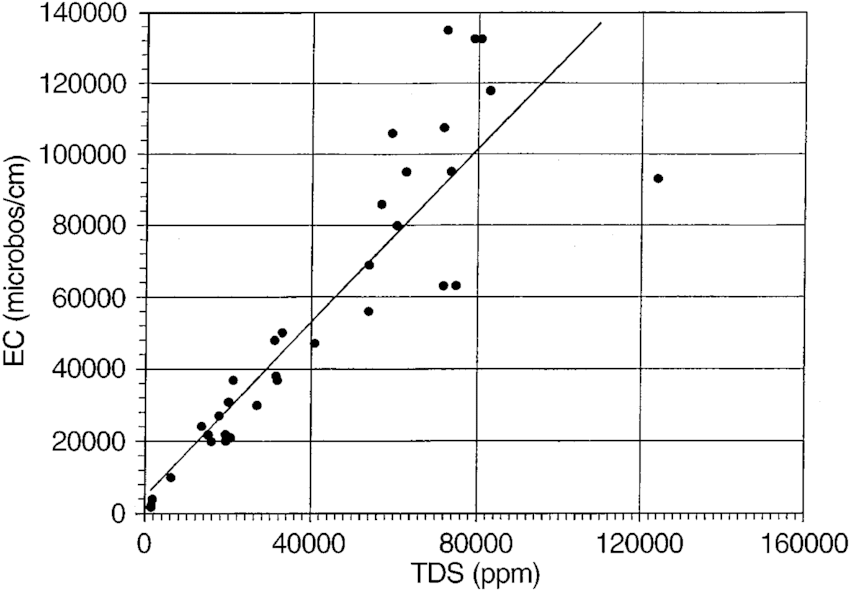

In [ ]:
TDS_EC_relation = sns.regplot(x="Solids", y="Conductivity", data=Water_Ch)

so we can use EC to get our model

In [ ]:
Water_Ch=Water_Ch.drop(["Solids"],axis=1)

In [ ]:
Water_Ch.columns

Conductivity

In [ ]:
Water_Conductivity=Water_Ch[(Water_Ch.Conductivity>400)]
outlimit_Conductivity=pd.Series(Water_Conductivity["Potability"].value_counts())
pd.DataFrame(outlimit_Conductivity)

EC is indication for solids also so we reclassify all wronge values according to WHO recommendations

In [ ]:
Water_Ch.loc[(Water_Ch.Conductivity>400),"Potability"]=0

In [ ]:
Water_Conductivity=Water_Ch[(Water_Ch.Conductivity>400)]
outlimit_Conductivity=pd.Series(Water_Conductivity["Potability"].value_counts())
pd.DataFrame(outlimit_Conductivity)

Chloramine

In [ ]:
Water_Chloramines=Water_Ch[Water_Ch.Chloramines>4]
outlimit_Chloramines=pd.Series(Water_Chloramines["Potability"].value_counts())
pd.DataFrame(outlimit_Chloramines)

Sulfate

In [ ]:
Water_Sulfate=Water_Ch[(Water_Ch.Sulfate<3) | (Water_Ch.Sulfate>30)]
outlimit_Sulfate=pd.Series(Water_Sulfate["Potability"].value_counts())
pd.DataFrame(outlimit_Sulfate)

Organic_carbon	

In [ ]:
Water_Organic_carbon=Water_Ch[Water_Ch.Organic_carbon>2]
outlimit_Organic_carbon=pd.Series(Water_Organic_carbon["Potability"].value_counts())
pd.DataFrame(outlimit_Organic_carbon)

6 samples would not pass test according to US EPA, where there is no international recommendations for it so we will keep it  

Trihalomethanes

In [ ]:
Water_Trihalomethanes=Water_Ch[Water_Ch.Trihalomethanes>80]
outlimit_Trihalomethanes=pd.Series(Water_Trihalomethanes["Potability"].value_counts())
pd.DataFrame(outlimit_Trihalomethanes)

Trihalomethanes is inlimits defined by WHO 

Turbidity

In [ ]:
Water_Turbidity=Water_Ch[Water_Ch.Turbidity!=5]
outlimit_Turbidity=pd.Series(Water_Turbidity["Potability"].value_counts())
pd.DataFrame(outlimit_Turbidity)

Turbidity classified correctly according to WHO

In [ ]:
Water_Ch.info()

In [ ]:
missing={"missing":Water_Ch.isnull().sum(),"% of missing":round(((Water_Ch.isnull().sum()/3276)*100),2)}
Missing_data=pd.DataFrame(missing)
Missing_data

so we have null values with ph by 491 record, with Sulfate by 781 and for Trihalomethanes by 162 record

In [ ]:
msn.bar(Water_Ch[["ph","Sulfate","Trihalomethanes","Potability"]])

In [ ]:
msn.matrix(Water_Ch[["ph","Sulfate","Trihalomethanes","Potability"]],n=0,p=0,sort=None,figsize=(13,15),width_ratios=(15, 1),color=(0,0.15,0.85),fontsize=16,labels=None,sparkline=True,inline=True,freq=None,ax=None)

In [ ]:
msn.heatmap(Water_Ch[["ph","Sulfate","Trihalomethanes","Potability"]],cmap="Reds")

we can drop the null values from Trihalomethanes while it only represent ~5% of the data 

In [ ]:
Water_Ch=Water_Ch.dropna(subset=["Trihalomethanes"])
Water_Ch.info()

In [ ]:
pd.DataFrame(Water_Ch[Water_Ch["Potability"]==0].Potability.value_counts())

In [ ]:
missing={"missing":Water_Ch.isnull().sum(),"% of missing":round(((Water_Ch.isnull().sum()/3114)*100),2)}
Missing_data=pd.DataFrame(missing)
Missing_data

we still have large null percentage for Sulfate 23.80%, pH 14.93% 

Now We can search for relationship between attributes to solve missing data problem

In [ ]:
sns.pairplot(Water_Ch, hue="Potability",palette=sequential_colors)

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(Water_Ch.corr(),annot=True,cmap="Reds")

There is no Linear correlation between attributes so we can not use any one to represent the other or to use it to fill th Null values

filling Nan with mean for pH values

In [ ]:
pH_nan_1 = Water_Ch.query('Potability == 1')['ph'][Water_Ch['ph'].isna()].index
Water_Ch.loc[pH_nan_1,'ph'] = Water_Ch.query('Potability == 1')['ph'][Water_Ch['ph'].notna()].mean()

pH_nan_0 = Water_Ch.query('Potability == 0')['ph'][Water_Ch['ph'].isna()].index
Water_Ch.loc[pH_nan_0,'ph'] = Water_Ch.query('Potability == 0')['ph'][Water_Ch['ph'].notna()].mean()

filling Nan with mean for Sulfate values

In [ ]:
Sulfate_nan_1=Water_Ch.query("Potability==1")["Sulfate"][Water_Ch["Sulfate"].isna()].index
Water_Ch.loc[Sulfate_nan_1,"Sulfate"]=Water_Ch.query("Potability==1")["Sulfate"][Water_Ch["Sulfate"].notna()].mean()
Sulfate_nan_0=Water_Ch.query("Potability==0")["Sulfate"][Water_Ch["Sulfate"].isna()].index
Water_Ch.loc[Sulfate_nan_0,"Sulfate"]=Water_Ch.query("Potability==0")["Sulfate"][Water_Ch["Sulfate"].notna()].mean()

In [ ]:
missing={"missing":Water_Ch.isnull().sum(),"% of missing":round(((Water_Ch.isnull().sum()/3114)*100),2)}
Missing_data=pd.DataFrame(missing)
Missing_data

In [ ]:
Potability=pd.Series(Water_Ch["Potability"].value_counts())
pd.DataFrame(Potability)

In [ ]:
plt.pie(Potability,labels=["Non-potable","potable"],startangle=90,explode=[0.3,0],colors=sequential_colors)

In [ ]:
217/(2897+217)

Potability Attribute has a Categorical data with two categories 0 for Non_Potabile water and 1 for Potabile

There are imbalance problem with this Categorical attribute so we will make synthetic Minority oversampling Technique 

In [ ]:
x=Water_Ch.drop(["Potability"],axis=1)
y=Water_Ch.Potability

In [ ]:
over=SMOTE(sampling_strategy=0.1,random_state=42)
under=RandomUnderSampler(sampling_strategy=0.5)
steps=[("O",over),("U",under)]
pipeline=Pipeline(steps=steps)
x_sm,y_sm=pipeline.fit_resample(x,y)
x_train,x_test,y_train,y_test=train_test_split(x_sm,y_sm,test_size=0.25,random_state =42)

In [ ]:
Water_Ch.describe()

In [ ]:
Water_Ch[["ph",
"Hardness",
"Chloramines",
"Sulfate",
"Conductivity"
,"Organic_carbon"
,"Trihalomethanes"
,"Turbidity"]].hist(bins=50, figsize=(20,16))

we make standardization using Robust Scaler to reduce the effect of outliers 

In [ ]:
RS=RobustScaler()
x_train=RS.fit_transform(x_train)
x_test=RS.transform(x_test)

Model selection

We will use gridsearch cross validation method to decide on the best parameters

SVC

In [ ]:
pipelineSVC = make_pipeline(SVC(random_state=42))
param_grid_svc = [{'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0,100],'svc__kernel': ['linear']},{'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],'svc__gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],'svc__kernel': ['rbf']}]

gsSVC = GridSearchCV(estimator=pipelineSVC,
                     param_grid = param_grid_svc,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)

gsSVC.fit(x_train, y_train)

print(gsSVC.best_score_)

print(gsSVC.best_params_)

print('Test accuracy: %.3f' % gsSVC.score(x_test, y_test))

clfSVC = gsSVC.best_estimator_
print('Test accuracy: %.3f' % clfSVC.score(x_test, y_test))

In [ ]:
svc=SVC(C=10,kernel="rbf",gamma=0.05,random_state=42)
svc.fit(x_train,y_train)
y_pred=svc.predict(x_test)
svc_train_acc=(svc.score(x_train,y_train))*100
svc_test_acc=(svc.score(x_test,y_test))*100
print(svc_test_acc,svc_train_acc)
print(pd.DataFrame(classification_report(y_test,y_pred,labels=[0,1],output_dict=True)))

KNN

In [ ]:
knn=KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train,y_train)
y_pred=knn.predict(x_test)
knn_train_acc=(knn.score(x_train,y_train))*100
knn_test_acc=(knn.score(x_test,y_test))*100
print(knn_train_acc,knn_test_acc)
print(pd.DataFrame(classification_report(y_test,y_pred,labels=[0,1],output_dict=True)))

Decision Tree

In [ ]:
pipelineDTC = make_pipeline(DecisionTreeClassifier(criterion='gini',random_state=42))
param_grid_dtc = [{
    'decisiontreeclassifier__max_depth':[2, 3,4,5],
    'decisiontreeclassifier__max_features':[2, 3, 4, 5, 6,7]
}]

gsDTC = GridSearchCV(estimator=pipelineDTC,
                     param_grid = param_grid_dtc,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)

gsDTC = gsDTC.fit(x_train, y_train)

print(gsDTC.best_score_)

print(gsDTC.best_params_)

clfDTC = gsDTC.best_estimator_
print('Test accuracy: %.3f' % clfDTC.score(x_test, y_test))

In [ ]:
dt=DecisionTreeClassifier(max_depth=5,max_features=7,criterion='gini',random_state=42)
dt.fit(x_train,y_train)
y_pred=dt.predict(x_test)
dt_train_acc=(dt.score(x_train,y_train))*100
dt_test_acc=(dt.score(x_test,y_test))*100
print(dt_train_acc, dt_test_acc)
print(pd.DataFrame(classification_report(y_test,y_pred,labels=[0,1],output_dict=True)))

RandomForest

In [ ]:
pipelineRFC = make_pipeline(RandomForestClassifier(criterion='gini', random_state=42))
param_grid_rfc = [{
    'randomforestclassifier__max_depth':[2, 3, 4],
    'randomforestclassifier__max_features':[2, 3, 4, 5, 6,7]
}]

gsRFC = GridSearchCV(estimator=pipelineRFC,
                     param_grid = param_grid_rfc,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)

gsRFC = gsRFC.fit(x_train, y_train)

print(gsRFC.best_score_)

print(gsRFC.best_params_)

clfRFC = gsRFC.best_estimator_
print('Test accuracy: %.3f' % clfRFC.score(x_test, y_test))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth=4,max_features=4,random_state=40)
rf.fit(x_train,y_train)
y_pred=rf.predict(x_test)
rf_train_acc=(rf.score(x_train,y_train))*100
rf_test_acc=(rf.score(x_test,y_test))*100
print(rf_train_acc,rf_test_acc)
print(pd.DataFrame(classification_report(y_test,y_pred,labels=[0,1],output_dict=True)))

In [ ]:
AL_ACC={"Algorithm":["Support Vector Cl","Kneighbor Cl","Decision Tree Cl","Random Forest"],"train_Accuracy":[svc_train_acc,knn_train_acc,dt_train_acc,rf_train_acc],"test_Accuracy":[svc_test_acc,knn_test_acc,dt_test_acc,rf_test_acc]}
pd.DataFrame(AL_ACC)

Conclussion 

The best Estimator is Random Forest Estimator with train accuracy equal 94, test accuracy 87.5 